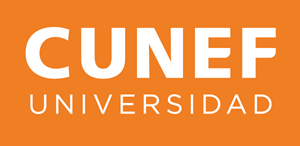
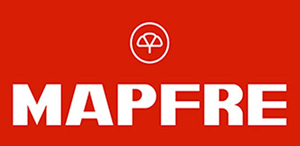

# Master en Data Science - Trabajo Final de Máster

# **2. Preprocesamiento**
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
### DataSet: *IBM - Telco Customer Churn*

## Librerías y funciones

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import importlib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed=10

In [337]:
sys.path.append('../src/')
import functions_rfc_IBM as fr
importlib.reload(fr)
sys.path.remove('../src/')

## Carga del Dataset + Filtrado

- Se efectúa la carga del set de datos, ya en formato Parquet
- Se genera una función en donde:
  - Se realiza también el filtrado que se determinó en el notebook anterior
  - Se determina el tipo de la variable 'Total Charges' como Float, ya que actualmente es String
- Se separa el set en X e y

In [338]:
df_telco_raw = pd.read_parquet('../data/ibm_telco_churn/df_telco_raw.parquet')
display(df_telco_raw.head(), df_telco_raw.shape)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


(7043, 33)

In [339]:
def df_filter_clean(df):
    """
    Filtrado y ajuste de tipos
        - Filtrado según variable tratamiento ('Tech Support')
        - Ajuste de tipo de variable 'Total Charges'
    """
    df = df[df['Tech Support'].isin(['Yes', 'No'])]
    df.loc[:,'Total Charges'] = df['Total Charges'].replace(' ', np.nan).astype(float)
    return df

In [340]:
df_telco = df_filter_clean(df_telco_raw)

In [341]:
df_telco['Payment Method'].value_counts()

Payment Method
Electronic check             2243
Bank transfer (automatic)    1212
Credit card (automatic)      1191
Mailed check                  871
Name: count, dtype: int64

In [342]:
X = df_telco.drop('Churn Value', axis=1)
y = df_telco['Churn Value']

In [343]:
X['Payment Method'].value_counts()

Payment Method
Electronic check             2243
Bank transfer (automatic)    1212
Credit card (automatic)      1191
Mailed check                  871
Name: count, dtype: int64

## Train-test Split

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.2
                                                    , random_state=seed
                                                    , stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4413, 32), (1104, 32), (4413,), (1104,))

In [345]:
X_train['Payment Method'].value_counts()

Payment Method
Electronic check             1787
Bank transfer (automatic)     967
Credit card (automatic)       953
Mailed check                  706
Name: count, dtype: int64

Se comprueba que se mantengan las distribuciones:

In [346]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Churn Value
 0    0.681622
 1    0.318378
 Name: proportion, dtype: float64,
 Churn Value
 0    0.682065
 1    0.317935
 Name: proportion, dtype: float64)

In [347]:
X_train['Tech Support'].value_counts(normalize=True), X_test['Tech Support'].value_counts(normalize=True)

(Tech Support
 No     0.629504
 Yes    0.370496
 Name: proportion, dtype: float64,
 Tech Support
 No     0.629529
 Yes    0.370471
 Name: proportion, dtype: float64)

Se exporta la separación en train y test:

###### (Se realiza previo al preprocesamiento debido a que éste será encapsulado en funciones que podrán ser usadas en notebooks subsiguientes)

In [348]:
pd.concat([X_train, y_train], axis=1).to_parquet('../data/ibm_telco_churn/df_telco_train.parquet')
pd.concat([X_test, y_test], axis=1).to_parquet('../data/ibm_telco_churn/df_telco_test.parquet')

## Funciones de selección de variables y preprocesamiento:

Se definen las funciones de selección y preprocesamiento de variables a continuación. A su vez, estas funciones se trasladan al script general de funciones para ser utilizadas en siguientes notebooks.

In [349]:
def feature_selection(df, add=[]):
    """
    ----------------------------------------------------------------------------------------------------------
    Función feature_selection:
    ----------------------------------------------------------------------------------------------------------
    - Funcionamiento: Recibe un DataFrame y un opcional de columnas extras a eliminar. Devuelve un DataFrame
    con las columnas del feature selection eliminadas, además de la columna extra en caso de haberse introducido.
    - Inputs:
        - df: DataFrame de Pandas al que se le reducirá el número de variables
        - add: argumento opcional en el que se pueden incluir más variables que se quieran eliminar
    - Return: DataFrame de pandas con las columnas reducidas según el feature selection aplicado.
    """
    drop = ['CustomerID'
            ,'Count'
            ,'Country'
            ,'State'
            ,'Zip Code'
            ,'Lat Long'
            ,'Latitude'
            ,'Longitude'
            ,'Churn Score'
            ,'Churn Label'
            ,'Churn Reason'
            ,'Total Charges'
            ,'Multiple Lines']
    if add != []:
        drop+=add
    df_new = df.drop(drop, axis=1)
    return df_new

In [350]:
def Preprocessing(df, cat_transf='mix', scale=True, cat_vars=None, num_vars=None, bool_vars=None,
                  vars_ord=[], vars_oh=[], not_scale=[], nulls_strategy='median', show_info=False):
    """
    ----------------------------------------------------------------------------------------------------------
    Preprocessing function:
    ----------------------------------------------------------------------------------------------------------
    - Description: Function that receives a dataframe and performs the preprocessing based on the parameters
                that the user chooses.
    - Inputs:
        - \033[1mdf:\033[0m dataframe to be preprocessed.
        - \033[1mcat_transf:\033[0m type of transformation for categorical variables. It can be 'ordinal',
        'onehot', 'mean' or 'mix'.
        - \033[1mscale:\033[0m boolean that indicates if the numeric variables should be scaled.
        - \033[1mcat_vars:\033[0m list of categorical variables to be transformed.
        - \033[1mnum_vars:\033[0m list of numeric variables to be transformed.
        - \033[1mbool_vars:\033[0m list of boolean variables to be transformed.
        - \033[1mvars_ord:\033[0m list of categorical variables to be transformed using ordinal encoding.
        - \033[1mvars_oh:\033[0m list of categorical variables to be transformed using onehot encoding.
        - \033[1mnot_scale:\033[0m list of numeric variables that should not be scaled.
        - \033[1mnulls_strategy:\033[0m strategy to fill null values in numeric variables. It can be 'mean',
        'median' or 'most_frequent'.
    
    - Output: preprocessor object that can be used in a pipeline.
    """

    # Defining transformers

    # Numeric transformer
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=nulls_strategy))
        ,('scaler', StandardScaler() if scale else 'passthrough')])
    
    # Categoircal transformers
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
        ,('ordinal', OrdinalEncoder())])
    onehot_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
        ,('onehot', OneHotEncoder(sparse_output=False))])
    mean_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
        ,('mean_encoder', TargetEncoder())])
    

    # Defining types of features
    df_bool, _, _ = fr.tipos_vars(df,False)

    if num_vars == None:
        num_vars = (df
                    .select_dtypes(include=['int64', 'float64'])
                    .drop(not_scale, axis=1)
                    .drop(df_bool, axis=1)
                    .columns)
    else:
        num_vars = np.array(num_vars)[~np.isin(num_vars, not_scale)]
    
    if bool_vars == None:
        bool_vars = df[df_bool].columns
    
    if cat_vars == None:
        cat_vars = df.select_dtypes(include=['object','string','category']).columns.values
    else:
        cat_vars = np.array(cat_vars)

    # Defining type of transformation for categorical variables
    if cat_transf=='ordinal':
        vars_ord = cat_vars.copy()
        cat_vars = []
    elif cat_transf=='onehot':
        vars_oh = cat_vars.copy()
        cat_vars = []
    elif cat_transf=='mix' and (vars_ord!=[] or vars_oh!=[]):
        cat_vars = cat_vars[~np.isin(cat_vars, [vars_ord + vars_oh])]
    elif cat_transf not in ['ordinal','onehot','mix','mean']:
        print('Error: cat_transf debe ser uno de los siguientes valores: "ordinal", "onehot", "mean" o "mix"')
        return None

    # Defining preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_vars),
            ('ordinal', ordinal_transformer, vars_ord),
            ('onehot', onehot_transformer, vars_oh),
            ('mean', mean_transformer, cat_vars),
            ('bool', ordinal_transformer, bool_vars)
            ]
        ,remainder='passthrough'
        ,verbose_feature_names_out=False).set_output(transform="pandas")
    
    if show_info:
        print(f'''Prprocessing pipeline defined with the following parameters:
        Mean encoding: {cat_vars}
        Numerical transformation (scaling={scale} input strategy={nulls_strategy}): {num_vars}
        Booleans encoding (ordinal 0-1): {bool_vars}
        Ordinal encoding: {vars_ord}
        One-Hot encoding: {vars_oh}''')

    return preprocessor

Se aplican las funciones a X y X_train:

In [351]:
X = (X
     .pipe(df_filter_clean)
     .pipe(feature_selection)
     .reset_index(drop=True)
)
display(X.head(), X.shape)

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,CLTV
0,Los Angeles,Male,No,No,No,2,Yes,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,3239
1,Los Angeles,Female,No,No,Yes,2,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,2701
2,Los Angeles,Female,No,No,Yes,8,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,5372
3,Los Angeles,Female,No,Yes,Yes,28,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,5003
4,Los Angeles,Male,No,No,Yes,49,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5340


(5517, 19)

In [352]:
X['Payment Method'].value_counts()

Payment Method
Electronic check             2243
Bank transfer (automatic)    1212
Credit card (automatic)      1191
Mailed check                  871
Name: count, dtype: int64

In [353]:
X_train  = (X_train
            .pipe(df_filter_clean)
            .pipe(feature_selection)
            .reset_index(drop=True)
)
display(X_train.head(), X_train.shape)

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,CLTV
0,San Marcos,Female,Yes,No,No,1,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,4432
1,Los Angeles,Male,No,Yes,Yes,43,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,4741
2,Rancho Palos Verdes,Female,No,No,No,30,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2655
3,Glendale,Male,Yes,Yes,No,57,No,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.85,5172
4,Herlong,Female,No,No,Yes,10,Yes,DSL,Yes,No,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.55,4434


(4413, 19)

In [354]:
# mean enconding to Payment Method:

mean_enc = TargetEncoder()
mean_enc.fit(X_train['Payment Method'].to_frame(), y_train)

X_train['Payment Method'] = mean_enc.transform(X_train['Payment Method'].to_frame())
X_test['Payment Method'] = mean_enc.transform(X_test['Payment Method'].to_frame())

X_train['Payment Method'].value_counts()

Payment Method
0.471083    1787
0.196576     967
0.190022     953
0.272015     706
Name: count, dtype: int64

In [355]:
X_train['Payment Method'].value_counts()

Payment Method
0.471083    1787
0.196576     967
0.190022     953
0.272015     706
Name: count, dtype: int64

In [356]:
bools, cats, nums = fr.tipos_vars(X)

(categoric)\(Type: object) - City : Unique values = 1127. Sample: ['Los Angeles' 'Beverly Hills' 'Huntington Park' 'Lynwood'
 'Marina Del Rey'] ... ['Laton' 'Belvedere Tiburon' 'Orick' 'Phillipsville' 'Salton City']
(boolean) - Gender :  ['Male' 'Female']
(boolean) - Senior Citizen :  ['No' 'Yes']
(boolean) - Partner :  ['No' 'Yes']
(boolean) - Dependents :  ['No' 'Yes']
(numeric) - Tenure Months : Range = [0.00 to 72.00], Mean = 32.88
(boolean) - Phone Service :  ['Yes' 'No']
(boolean) - Internet Service :  ['DSL' 'Fiber optic']
(boolean) - Online Security :  ['Yes' 'No']
(boolean) - Online Backup :  ['Yes' 'No']
(boolean) - Device Protection :  ['No' 'Yes']
(boolean) - Tech Support :  ['No' 'Yes']
(boolean) - Streaming TV :  ['No' 'Yes']
(boolean) - Streaming Movies :  ['No' 'Yes']
(categoric)(Type: object) - Contract : ['Month-to-month', 'One year', 'Two year']
(boolean) - Paperless Billing :  ['Yes' 'No']
(categoric)(Type: object) - Payment Method : ['Bank transfer (automatic)', 'C

In [357]:
Preprocessing(X, cat_vars=cats, num_vars=nums, bool_vars=bools, show_info=False)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 array(['Tenure Months', 'Monthly Charges', 'CLTV'], dtype='<U15')),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 []),
                                ('on...
                                ('bool',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Phone Service',
                                  'Internet Service', 'Online Security',
                                  'Online Backup', 'Device Protection',
                                  'Tech Support', 'Streaming TV',
                                  'Streaming Movies', 'Paperless Billing'])],
                  verbose_feature_names_out=False)

In [358]:
preproces = Preprocessing(X, cat_transf='mix', scale=True, cat_vars=cats, num_vars=nums, bool_vars=bools, show_info=False, vars_ord=['Contract'])

preproces.fit(X, y)

X_t = preproces.transform(X)

X_t['Payment Method'].value_counts()

Payment Method
0.470720    2243
0.198092    1212
0.187315    1191
0.272149     871
Name: count, dtype: int64

In [359]:
preprocesor = Preprocessing(df=X
                            ,cat_transf='mix'
                            ,scale=False
                            ,cat_vars=cats
                            ,num_vars=nums
                            ,bool_vars=bools
                            ,vars_ord=['Contract']
                            ,show_info=True)

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['City' 'Payment Method']
        Numerical transformation (scaling=False input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [360]:
preprocesor.fit(X, y)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', 'passthrough')]),
                                 array(['Tenure Months', 'Monthly Charges', 'CLTV'], dtype='<U15')),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Contract'...
                                ('bool',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Gender', 'Senior Citizen', 'Partner',
                                  'Dependents', 'Phone Service',
                                  'Internet Service', 'Online Security',
                                  'Online Backup', 'Device Protection',
                                  'Tech Support', 'Streaming TV',
                                  'Streaming Movies', 'Paperless Billing'])],
                  verbose_feature_names_out=False)

In [361]:
X_t = preprocesor.transform(X)

In [362]:
X_t['Payment Method'].value_counts()

Payment Method
0.470720    2243
0.198092    1212
0.187315    1191
0.272149     871
Name: count, dtype: int64

In [99]:
X_t

,Tenure Months,Monthly Charges,CLTV,Contract,City,Payment Method,Gender,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing
0,2.0,53.85,3239.0,0.0,0.357310,0.269404,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2.0,70.70,2701.0,0.0,0.366575,0.472201,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8.0,99.65,5372.0,0.0,0.366575,0.472201,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3,28.0,104.80,5003.0,0.0,0.362451,0.470168,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,49.0,103.70,5340.0,0.0,0.387564,0.201552,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,12.0,60.65,3740.0,1.0,0.000000,0.472294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5513,24.0,84.80,2140.0,1.0,0.000000,0.269404,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
5514,72.0,103.20,5560.0,1.0,0.000000,0.187272,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
5515,11.0,29.60,2793.0,0.0,1.000000,0.466870,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
preprocesor = Preprocessing(df=X_train
                            ,cat_transf='mix'
                            ,scale=False
                            ,cat_vars=cats
                            ,num_vars=nums
                            ,bool_vars=bools
                            ,vars_ord=['Contract']
                            ,show_info=True)

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['City' 'Payment Method']
        Numerical transformation (scaling=False input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [55]:
X_t_noscaled = preprocesor.fit_transform(X_train, y_train)

In [50]:
preprocesor = Preprocessing(df=X_train
                            ,cat_transf='mix'
                            ,scale=True
                            ,cat_vars=cats
                            ,num_vars=nums
                            ,bool_vars=bools
                            ,vars_ord=['Contract']
                            ,show_info=True)

X_t_scaled = preprocesor.fit_transform(X_train, y_train)

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['City' 'Payment Method']
        Numerical transformation (scaling=True input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


In [51]:
X_t_noscaled.shape, X_t_scaled.shape

((4413, 19), (4413, 19))

In [56]:
X_t_noscaled

,Tenure Months,Monthly Charges,CLTV,Contract,City,Payment Method,Gender,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing
0,1.0,72.10,4432.0,0.0,0.549001,0.464614,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,43.0,29.30,4741.0,0.0,0.383634,0.201150,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,30.0,79.30,2655.0,1.0,0.000000,0.190726,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,57.0,44.85,5172.0,0.0,0.239159,0.464614,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,10.0,73.55,4434.0,1.0,0.000000,0.188201,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4408,22.0,83.30,3804.0,0.0,0.578016,0.465894,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4409,45.0,73.85,5264.0,2.0,1.000000,0.183238,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4410,38.0,94.75,3654.0,0.0,0.372826,0.470018,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4411,52.0,80.20,5597.0,1.0,0.588536,0.270726,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Se revisa la correcta codificación de las variables:

In [22]:
display(X_t_noscaled[bools+['Contract']].head(),X[bools+['Contract']].head())

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Contract
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


,Gender,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Contract
0,Male,No,No,No,Yes,DSL,Yes,Yes,No,No,No,No,Yes,Month-to-month
1,Female,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Yes,Month-to-month
2,Female,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Month-to-month
3,Female,No,Yes,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,Month-to-month
4,Male,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Month-to-month


Se muestra de que manera se han codificado cada uno de los valores de las variables booleanas / categóricas mediante el Ordinal Encoding:

In [23]:
for i in range(len(bools+['Contract'])):
    dic = {}
    for k,v in zip(sorted(X[bools+['Contract']].iloc[:,i].unique().tolist()), sorted(X_t_noscaled[bools+['Contract']].iloc[:,i].unique().tolist())):
              dic[k] = v
    print(f"{[bools+['Contract']][0][i]}: {dic}")

Gender: {'Female': 0.0, 'Male': 1.0}
Senior Citizen: {'No': 0.0, 'Yes': 1.0}
Partner: {'No': 0.0, 'Yes': 1.0}
Dependents: {'No': 0.0, 'Yes': 1.0}
Phone Service: {'No': 0.0, 'Yes': 1.0}
Internet Service: {'DSL': 0.0, 'Fiber optic': 1.0}
Online Security: {'No': 0.0, 'Yes': 1.0}
Online Backup: {'No': 0.0, 'Yes': 1.0}
Device Protection: {'No': 0.0, 'Yes': 1.0}
Tech Support: {'No': 0.0, 'Yes': 1.0}
Streaming TV: {'No': 0.0, 'Yes': 1.0}
Streaming Movies: {'No': 0.0, 'Yes': 1.0}
Paperless Billing: {'No': 0.0, 'Yes': 1.0}
Contract: {'Month-to-month': 0.0, 'One year': 1.0, 'Two year': 2.0}


In [24]:
X_train['Payment Method'].value_counts()

Payment Method
Electronic check             1787
Bank transfer (automatic)     967
Credit card (automatic)       953
Mailed check                  706
Name: count, dtype: int64

In [25]:
X_t_noscaled['Payment Method'].value_counts()

Payment Method
0.481348    383
0.473928    361
0.471826    361
0.461316    361
0.467141    321
0.187962    213
0.208005    207
0.192275    202
0.190028    200
0.189237    195
0.199341    189
0.189975    184
0.186648    181
0.195487    175
0.194312    174
0.275746    151
0.270687    148
0.273776    147
0.286765    134
0.253546    126
Name: count, dtype: int64

## Cálculo de importancia de variables

Mediante el uso del Random Forest se realiza un análisis de importancia de variables con el fin de alivianar el modelo y resguardar solo las variables relevantes

Para ello, se utiliza una variable random como guía para determinar un "punto de corte" sobre las variables analizadas

In [23]:
X_t_selection = X_t.copy()
X_t_selection['-----------Random_control-----------'] = np.random.randint(1,1000,X_t_selection.shape[0])
X_t_selection

,Tenure Months,Monthly Charges,CLTV,Contract,City,Payment Method,Gender,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,-----------Random_control-----------
0,2.0,53.85,3239.0,0.0,0.335042,0.269791,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,882
1,2.0,70.70,2701.0,0.0,0.335042,0.473032,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,439
2,8.0,99.65,5372.0,0.0,0.376633,0.473879,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,998
3,28.0,104.80,5003.0,0.0,0.374670,0.468025,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,369
4,49.0,103.70,5340.0,0.0,0.351861,0.206387,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,12.0,60.65,3740.0,1.0,0.000000,0.473879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,90
5513,24.0,84.80,2140.0,1.0,0.000000,0.270449,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,755
5514,72.0,103.20,5560.0,1.0,0.000000,0.184583,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,793
5515,11.0,29.60,2793.0,0.0,0.433589,0.473032,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,9


In [65]:
%%time
clf = RandomForestClassifier(max_depth=5, random_state=seed)
clf.fit(X_t_selection, y)

CPU times: total: 281 ms
Wall time: 704 ms


RandomForestClassifier(max_depth=5, random_state=10)

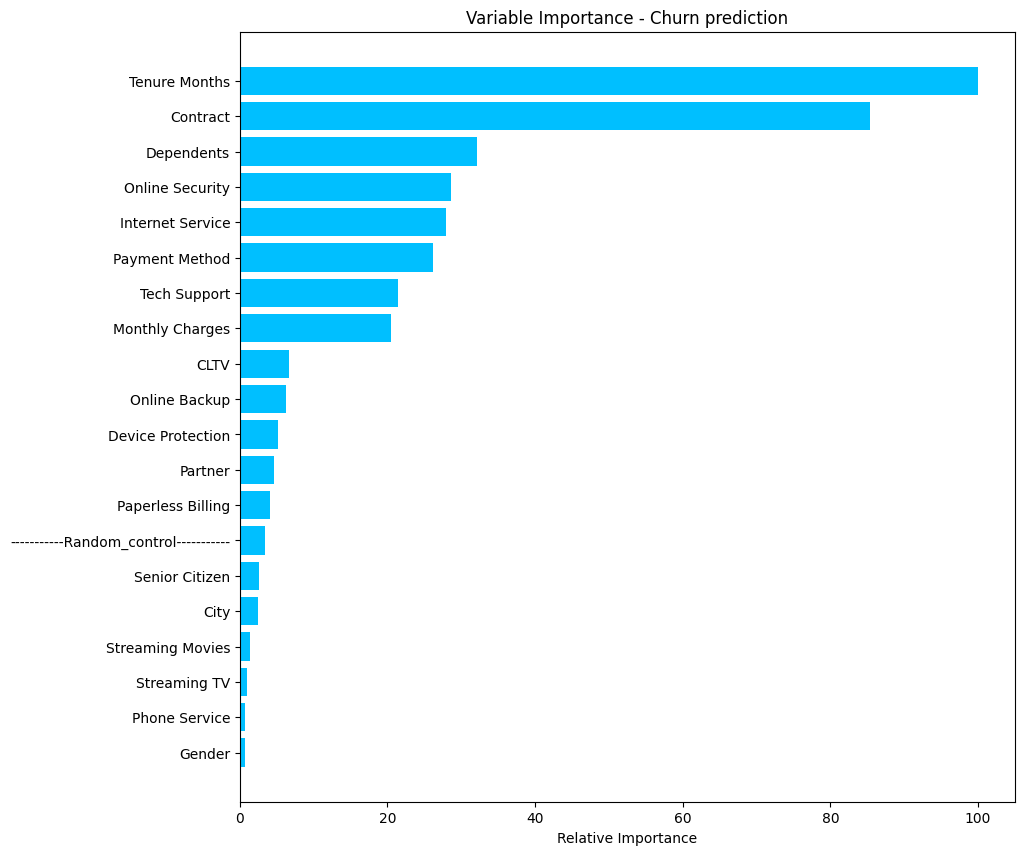

In [66]:
feature_importance = clf.feature_importances_ 
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='deepskyblue')
plt.yticks(pos, X_t_selection.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Churn prediction')
plt.show()

Como aparentaba en el EDA, hay algunas variables más que no aportarán mucho al modelo debido a su baja relación con el target, por lo que se procederá a eliminarlas.

Las únicas variables por debajo del control random que se mantendrán serán "Señor Citizen" y "Phone Service", debido a que en el análisis gráfico parecía posible que marquen alguna diferencia en relación al target y es preferible ser conservadores en este sentido.

Por ende, la función de selección de variables quedaría así:

In [24]:
def feature_selection(df, add=[]):
    """
    ----------------------------------------------------------------------------------------------------------
    Función feature_selection:
    ----------------------------------------------------------------------------------------------------------
    - Funcionamiento: Recibe un DataFrame y un opcional de columnas extras a eliminar. Devuelve un DataFrame
    con las columnas del feature selection eliminadas, además de la columna extra en caso de haberse introducido.
    - Inputs:
        - df: DataFrame de Pandas al que se le reducirá el número de variables
        - add: argumento opcional en el que se pueden incluir más variables que se quieran eliminar
    - Return: DataFrame de pandas con las columnas reducidas según el feature selection aplicado.
    """
    drop = ['CustomerID'
            ,'Count'
            ,'Country'
            ,'State'
            ,'Zip Code'
            ,'Lat Long'
            ,'Latitude'
            ,'Longitude'
            ,'Churn Score'
            ,'Churn Label'
            ,'Churn Reason'
            ,'Total Charges'
            ,'Multiple Lines'
            ,'City'
            ,'Streaming Movies'
            ,'Streaming TV'
            ,'Gender']
    if add != []:
        drop+=add
    df_new = df.drop(drop, axis=1)
    return df_new

Las funciones generadas en este notebook serán trasladadas al script auxiliar de funciones para su uso posterior

## Nuevo diccionario de datos previo al modelado

### Extra - Importancia de variables del Treatment

Además de calcular la importancia de variables para la predicción del Outcome, también se aprovechó para realizar, a modo de curiosidad, el mismo modelo pero en este caso para revisar las variables a priori más influyentes para la variable Target.

In [146]:
%%time
clf_treat = RandomForestClassifier(max_depth=5, random_state=seed)
clf_treat.fit(X_t_selection.drop('Tech Support', axis=1), X_t_selection['Tech Support'])

CPU times: total: 328 ms
Wall time: 476 ms


RandomForestClassifier(max_depth=5, random_state=10)

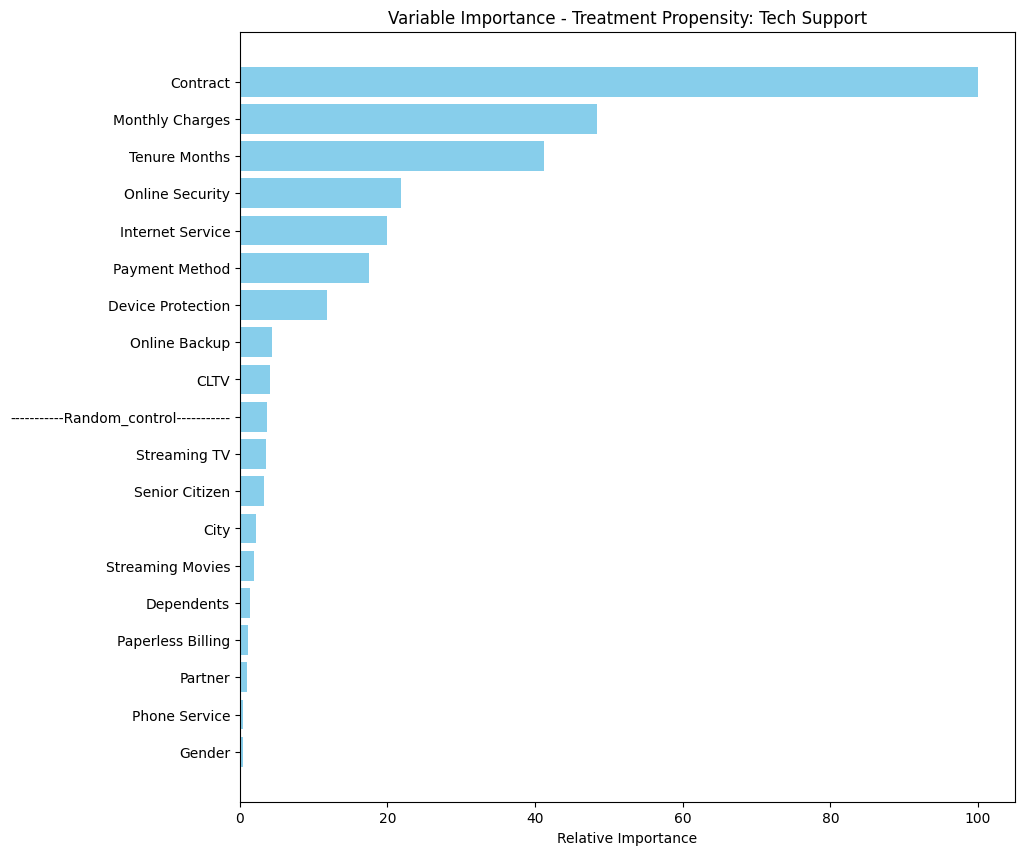

In [158]:
feature_importance = clf_treat.feature_importances_ 
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='skyblue')
plt.yticks(pos, X_t_selection.drop('Tech Support', axis=1).keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance - Treatment Propensity: Tech Support')
plt.show()